Este es la primera version de mi sistema de clasificación de imagenes.

Para ejecutar correctamente el código hay que crear 2 carpetas en /content, una de Personas y otra de Comidas donde se subirán las imágenes para el entrenamiento y test.

--- CARGANDO Y PROCESANDO IMÁGENES ---
Leyendo 51 archivos en 'Personas'
Leyendo 110 archivos en 'Comidas'

Total imágenes válidas cargadas: 160
Entrenamiento: 128 imágenes
Test (Prueba): 32 imágenes

INICIANDO CLASIFICACIÓN
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


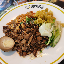

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


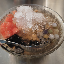

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


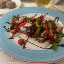

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


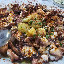

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Conflicto -> Gana KNN] -> CORRECTO


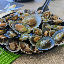

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


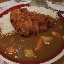

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


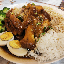

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


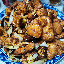

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


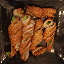

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


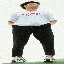

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


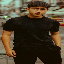

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


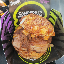

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


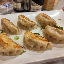

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Conflicto -> Gana KNN] -> CORRECTO


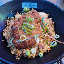

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


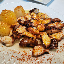

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


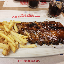

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


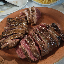

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


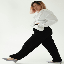

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


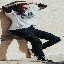

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


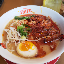

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


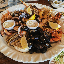

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Conflicto -> Gana KNN] -> CORRECTO


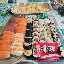

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


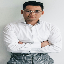

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Conflicto -> Gana KNN] -> CORRECTO


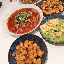

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


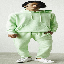

--------------------
Img: Comidas -> Sistema dice: Personas
   [Conflicto -> Gana KNN] -> FALLO


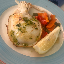

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


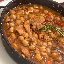

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


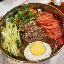

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


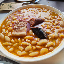

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Conflicto -> Gana KNN] -> CORRECTO


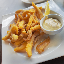

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


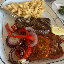

--------------------
Img: Personas -> Sistema dice: Comidas
   [Acuerdo] -> FALLO


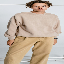

--------------------

ESTADÍSTICAS FINALES:
Precisión Global: 93.75%
Conflictos entre KNN y MVN: 6 de 32 casos.
Nota: Un 'conflicto' significa que los algoritmos no estaban de acuerdo,
pero el sistema híbrido tomó una decisión final.


In [15]:
import cv2
import numpy as np
import os
import random
from google.colab.patches import cv2_imshow

#Extracción de características
def extraer_caracteristicas(ruta_imagen):
    """
    Lee una imagen y extrae su Histograma de color.
    """
    #Leemos la imagen
    img = cv2.imread(ruta_imagen)

    # Si la imagen está rota o no se lee, se devuleve none
    if img is None:
        return None

    # Redimensionamos a 64x64
    img = cv2.resize(img, (64, 64))

    #Calculo del Histograma de color (RGB)
    # 8 bins por canal (8x8x8 = 512 características por imagen)
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])

    #Normalizar el histograma
    cv2.normalize(hist, hist)

    #Aplanar el resultado en un vector de una sola fila
    return hist.flatten(), img

#Calculo de distancia para KNN
def distancia_euclidiana(v1, v2):
    """
    Calcula la distancia matemática entre dos vectores (imágenes).
    Fórmula: Raíz cuadrada de la suma de las diferencias al cuadrado.
    """
    return np.sqrt(np.sum((v1 - v2)**2))

#Algoritmo KNN (K-Vecinos más cercanos)
def obtener_voto_knn(k, X_train, y_train, vector_nuevo):
    distancias = []

    #Calculamos distancia contra todas las imágenes de entrenamiento
    for i in range(len(X_train)):
        dist = distancia_euclidiana(vector_nuevo, X_train[i])
        distancias.append((dist, y_train[i]))

    #Ordenamos de menor a mayor distancia(mas parecidos primero)
    distancias.sort(key=lambda x: x[0])

    #Se coge los K vecinos más cercanos
    vecinos = distancias[:k]

    conteo = {}
    for _, etiqueta in vecinos:
        conteo[etiqueta] = conteo.get(etiqueta, 0) + 1

    ganador = sorted(conteo.items(), key=lambda item: item[1], reverse=True)[0][0]
    return ganador

#Algoritmo MVN
def entrenar_centroides(X_train, y_train):
    """
    Calcula la imagen 'promedio' de Personas y de Comidas.
    """
    #Filtramos los datos por clase
    datos_personas = X_train[y_train == "Personas"]
    datos_comidas = X_train[y_train == "Comidas"]

    #Si no hay datos suficientes para entrenar, devolvemos ceros para evitar error
    if len(datos_personas) == 0 or len(datos_comidas) == 0:
        print("Error crítico: Falta una de las clases en el entrenamiento.")
        return np.zeros(512), np.zeros(512)

    #Calculamos la media (axis=0 significa promedio vertical de las columnas)
    c_personas = np.mean(datos_personas, axis=0)
    c_comidas = np.mean(datos_comidas, axis=0)

    return c_personas, c_comidas

def obtener_voto_mvn(c_personas, c_comidas, vector_nuevo):
    """
    Clasifica según a qué 'promedio' se parece más.
    """
    d_pers = distancia_euclidiana(vector_nuevo, c_personas)
    d_comi = distancia_euclidiana(vector_nuevo, c_comidas)

    if d_pers < d_comi:
        return "Personas"
    else:
        return "Comidas"


#Sistema híbrido
def clasificador_hibrido(vector, X_train, y_train, c_pers, c_comi):
    #1. Preguntamos al KNN (K=3)
    voto_knn = obtener_voto_knn(3, X_train, y_train, vector)

    #2. Preguntamos al MVN (Centroides)
    voto_mvn = obtener_voto_mvn(c_pers, c_comi, vector)

    decision = ""
    confianza = ""

    #3. Fusión de decisiones
    if voto_knn == voto_mvn:
        decision = voto_knn
        confianza = "Acuerdo"
    else:
        #En caso de duda se elige KNN
        decision = voto_knn
        confianza = "Conflicto -> Gana KNN"

    return decision, confianza

#Programa main
def main():
    ruta_base = '/content'
    carpetas = ["Personas", "Comidas"]

    print("--- CARGANDO Y PROCESANDO IMÁGENES ---")

    X = [] #Aqui guardaremos los vectores (números)
    y = [] #Aqui guardaremos las etiquetas ("Personas" o "Comidas")
    imagenes_visuales = [] #Aqui guardamos las imagenes

    #Verificación de seguridad
    if not os.path.exists(ruta_base):
        print(f"No encuentro la carpeta {ruta_base}")
        print("Por favor, verifica que la carpeta 'Dataset' está creada y escrita exactamente así.")
        return

    for carpeta in carpetas:
        ruta_completa = os.path.join(ruta_base, carpeta)

        if not os.path.exists(ruta_completa):
            print(f"No encuentro la subcarpeta '{ruta_completa}'")
            continue

        archivos = os.listdir(ruta_completa)
        print(f"Leyendo {len(archivos)} archivos en '{carpeta}'")

        for archivo in archivos:
            #Filtro simple para asegurar que es imagen
            if archivo.lower().endswith(('.jpg', '.jpeg', '.png')):
                ruta_img = os.path.join(ruta_completa, archivo)

                #Llamada al bloque de Visión Artificial
                res = extraer_caracteristicas(ruta_img)

                if res is not None:
                    vector, img_orig = res
                    X.append(vector)
                    y.append(carpeta)
                    imagenes_visuales.append(img_orig)

    X = np.array(X)
    y = np.array(y)

    print(f"\nTotal imágenes válidas cargadas: {len(X)}")

    #Se va a coger 80% de imagenes para entrenamiento y 20% para test
    indices = list(range(len(X)))
    random.shuffle(indices) #Mezclamos aleatoriamente

    punto_corte = int(len(X) * 0.8)
    idx_train = indices[:punto_corte]
    idx_test = indices[punto_corte:]

    X_train, y_train = X[idx_train], y[idx_train]
    X_test, y_test = X[idx_test], y[idx_test]
    imgs_test = [imagenes_visuales[i] for i in idx_test]

    print(f"Entrenamiento: {len(X_train)} imágenes")
    print(f"Test (Prueba): {len(X_test)} imágenes")

    #Fase de Aprendizaje
    centroide_pers, centroide_comi = entrenar_centroides(X_train, y_train)

    #Fase de Test
    print("\n" + "="*40)
    print("INICIANDO CLASIFICACIÓN")
    print("="*40)

    aciertos = 0
    conflictos = 0

    for i in range(len(X_test)):
        vector_prueba = X_test[i]
        etiqueta_real = y_test[i]

        prediccion, confianza = clasificador_hibrido(
            vector_prueba, X_train, y_train, centroide_pers, centroide_comi
        )

        #Verificamos si acertó
        if prediccion == etiqueta_real:
            resultado = "CORRECTO"
            aciertos += 1
        else:
            resultado = "FALLO"

        if "Conflicto" in confianza:
            conflictos += 1

        #Mostramos detalle de cada prueba
        print(f"Img: {etiqueta_real} -> Sistema dice: {prediccion}")
        print(f"   [{confianza}] -> {resultado}")

        #Se muestra las imagenes test
        if i < len(X_test):
            cv2_imshow(imgs_test[i])
        print("-" * 20)

    #Resultados
    if len(X_test) > 0:
        precision = (aciertos / len(X_test)) * 100
        print(f"\nESTADÍSTICAS FINALES:")
        print(f"Precisión Global: {precision:.2f}%")
        print(f"Conflictos entre KNN y MVN: {conflictos} de {len(X_test)} casos.")
        print("Nota: Un 'conflicto' significa que los algoritmos no estaban de acuerdo,")
        print("pero el sistema híbrido tomó una decisión final.")
    else:
        print("No hay imágenes en el conjunto de test.")

if __name__ == "__main__":
    main()

Este es la segunda versión que añade un filtro de bordes(Sobel) para la textura/forma.

Los resultados son idénticos al primero también para los conflictos y la tasa de aciertos con KNN es más alto que MVN.

--- CARGANDO Y PROCESANDO IMÁGENES (CON SOBEL) ---
Leyendo 51 archivos en 'Personas'
Leyendo 110 archivos en 'Comidas'

Total imágenes válidas cargadas: 160
Entrenamiento: 128 imágenes
Test (Prueba): 32 imágenes

INICIANDO CLASIFICACIÓN
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


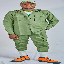

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


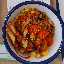

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


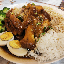

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


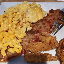

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


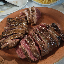

--------------------
Img: Comidas -> Sistema dice: Personas
   [Acuerdo] -> FALLO


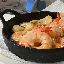

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


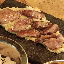

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


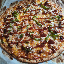

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


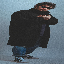

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


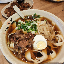

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


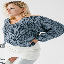

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


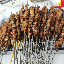

--------------------
Img: Personas -> Sistema dice: Comidas
   [Acuerdo] -> FALLO


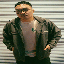

--------------------
Img: Personas -> Sistema dice: Personas
   [Conflicto -> Gana KNN] -> CORRECTO


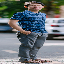

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


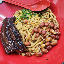

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


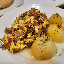

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


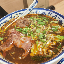

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


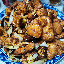

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


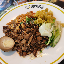

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Conflicto -> Gana KNN] -> CORRECTO


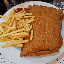

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


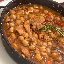

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


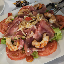

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


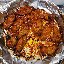

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


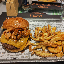

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


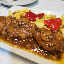

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


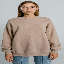

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


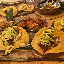

--------------------
Img: Personas -> Sistema dice: Personas
   [Acuerdo] -> CORRECTO


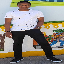

--------------------
Img: Personas -> Sistema dice: Comidas
   [Acuerdo] -> FALLO


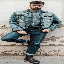

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Acuerdo] -> CORRECTO


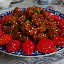

--------------------
Img: Personas -> Sistema dice: Comidas
   [Acuerdo] -> FALLO


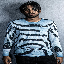

--------------------
Img: Comidas -> Sistema dice: Comidas
   [Conflicto -> Gana KNN] -> CORRECTO


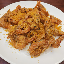

--------------------

ESTADÍSTICAS FINALES:
Precisión Global: 87.50%
Conflictos entre KNN y MVN: 3 de 32 casos.


In [22]:
import cv2
import numpy as np
import os
import random
from google.colab.patches import cv2_imshow

#Extracción de características
def extraer_caracteristicas(ruta_imagen):
    """
    Lee una imagen y extrae un vector híbrido:
    - Color (Histograma)
    - Textura/Forma (Bordes Sobel)
    """
    #Leemos la imagen
    img = cv2.imread(ruta_imagen)

    #Si la imagen está rota o no se lee, se devuelve None
    if img is None:
        return None

    #Redimensionamos a 64x64
    img = cv2.resize(img, (64, 64))

    #Histograma RGB
    # 8 bins por canal (8x8x8 = 512 características)
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    vector_color = hist.flatten()

    #Filtro Sobel
    # Convertimos a escala de grises para analizar bordes
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Aplicamos Sobel en X e Y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    #Calculamos la magnitud (fuerza) de los bordes
    magnitud = cv2.magnitude(sobel_x, sobel_y)

    #Extraemos estadísticas: Media (cantidad de bordes) y Desviación
    media_bordes = np.mean(magnitud)
    desvio_bordes = np.std(magnitud)

    #Creamos un vector pequeño de textura y le damos peso (x5)
    vector_textura = np.array([media_bordes, desvio_bordes]) * 5

    #Unimos los 512 datos de color con los 2 datos de textura = 514 datos
    vector_final = np.concatenate((vector_color, vector_textura))

    return vector_final, img

def distancia_euclidiana(v1, v2):
    """
    Calcula la distancia matemática entre dos vectores.
    """
    return np.sqrt(np.sum((v1 - v2)**2))

#Algoritmo KNN
def obtener_voto_knn(k, X_train, y_train, vector_nuevo):
    distancias = []

    #Calculamos distancia contra todas las imágenes de entrenamiento
    for i in range(len(X_train)):
        dist = distancia_euclidiana(vector_nuevo, X_train[i])
        distancias.append((dist, y_train[i]))

    #Ordenamos de menor a mayor distancia
    distancias.sort(key=lambda x: x[0])

    #Se coge los K vecinos más cercanos
    vecinos = distancias[:k]

    conteo = {}
    for _, etiqueta in vecinos:
        conteo[etiqueta] = conteo.get(etiqueta, 0) + 1

    ganador = sorted(conteo.items(), key=lambda item: item[1], reverse=True)[0][0]
    return ganador

#Algoritmo MVN
def entrenar_centroides(X_train, y_train):
    """
    Calcula la imagen 'promedio' de Personas y de Comidas.
    """
    #Filtramos los datos por clase
    datos_personas = X_train[y_train == "Personas"]
    datos_comidas = X_train[y_train == "Comidas"]

    #Detectamos el tamaño del vector dinámicamente (ahora es 514)
    if len(X_train) > 0:
        tamano_vector = X_train.shape[1]
    else:
        tamano_vector = 512 # Valor por defecto si falla todo

    #Si no hay datos suficientes para entrenar una clase
    if len(datos_personas) == 0 or len(datos_comidas) == 0:
        print("Error crítico: Falta una de las clases en el entrenamiento.")
        return np.zeros(tamano_vector), np.zeros(tamano_vector)

    #Calculamos la media
    c_personas = np.mean(datos_personas, axis=0)
    c_comidas = np.mean(datos_comidas, axis=0)

    return c_personas, c_comidas

def obtener_voto_mvn(c_personas, c_comidas, vector_nuevo):
    """
    Clasifica según a qué 'promedio' se parece más.
    """
    d_pers = distancia_euclidiana(vector_nuevo, c_personas)
    d_comi = distancia_euclidiana(vector_nuevo, c_comidas)

    if d_pers < d_comi:
        return "Personas"
    else:
        return "Comidas"

#Sistema hibrido
def clasificador_hibrido(vector, X_train, y_train, c_pers, c_comi):
    #Preguntamos al KNN (K=3)
    voto_knn = obtener_voto_knn(3, X_train, y_train, vector)

    #Preguntamos al MVN (Centroides)
    voto_mvn = obtener_voto_mvn(c_pers, c_comi, vector)

    decision = ""
    confianza = ""

    #Fusión de decisiones
    if voto_knn == voto_mvn:
        decision = voto_knn
        confianza = "Acuerdo"
    else:
        #En caso de duda se elige KNN
        decision = voto_knn
        confianza = "Conflicto -> Gana KNN"

    return decision, confianza

#Programa principal
def main():
    ruta_base = '/content'
    carpetas = ["Personas", "Comidas"]

    print("--- CARGANDO Y PROCESANDO IMÁGENES ---")

    X = [] #Vectores
    y = [] #Etiquetas
    imagenes_visuales = [] #Imágenes originales para mostrar

    #Verificación de seguridad
    if not os.path.exists(ruta_base):
        print(f"No encuentro la carpeta {ruta_base}")
        return

    for carpeta in carpetas:
        ruta_completa = os.path.join(ruta_base, carpeta)

        if not os.path.exists(ruta_completa):
            print(f"No encuentro la subcarpeta '{ruta_completa}'")
            continue

        archivos = os.listdir(ruta_completa)
        print(f"Leyendo {len(archivos)} archivos en '{carpeta}'")

        for archivo in archivos:
            if archivo.lower().endswith(('.jpg', '.jpeg', '.png')):
                ruta_img = os.path.join(ruta_completa, archivo)

                res = extraer_caracteristicas(ruta_img)

                if res is not None:
                    vector, img_orig = res
                    X.append(vector)
                    y.append(carpeta)
                    imagenes_visuales.append(img_orig)

    X = np.array(X)
    y = np.array(y)

    print(f"\nTotal imágenes válidas cargadas: {len(X)}")

    if len(X) < 5:
        print("No hay suficientes imágenes para entrenar.")
        return

    # Separación 80% train / 20% test
    indices = list(range(len(X)))
    random.shuffle(indices)

    punto_corte = int(len(X) * 0.8)
    idx_train = indices[:punto_corte]
    idx_test = indices[punto_corte:]

    X_train, y_train = X[idx_train], y[idx_train]
    X_test, y_test = X[idx_test], y[idx_test]
    imgs_test = [imagenes_visuales[i] for i in idx_test]

    print(f"Entrenamiento: {len(X_train)} imágenes")
    print(f"Test (Prueba): {len(X_test)} imágenes")

    #Fase de Aprendizaje
    centroide_pers, centroide_comi = entrenar_centroides(X_train, y_train)

    #Fase de Test
    print("\n" + "="*40)
    print("INICIANDO CLASIFICACIÓN")
    print("="*40)

    aciertos = 0
    conflictos = 0

    for i in range(len(X_test)):
        vector_prueba = X_test[i]
        etiqueta_real = y_test[i]

        prediccion, confianza = clasificador_hibrido(
            vector_prueba, X_train, y_train, centroide_pers, centroide_comi
        )

        #Verificamos si acertó
        if prediccion == etiqueta_real:
            resultado = "CORRECTO"
            aciertos += 1
        else:
            resultado = "FALLO"

        if "Conflicto" in confianza:
            conflictos += 1

        #Mostramos detalle de cada prueba
        print(f"Img: {etiqueta_real} -> Sistema dice: {prediccion}")
        print(f"   [{confianza}] -> {resultado}")

        #Se muestra las imágenes test
        if i < len(X_test):
            cv2_imshow(imgs_test[i])
        print("-" * 20)

    if len(X_test) > 0:
        precision = (aciertos / len(X_test)) * 100
        print(f"\nESTADÍSTICAS FINALES:")
        print(f"Precisión Global: {precision:.2f}%")
        print(f"Conflictos entre KNN y MVN: {conflictos} de {len(X_test)} casos.")
    else:
        print("No hay imágenes en el conjunto de test.")

if __name__ == "__main__":
    main()

Esta es la tercera versión, donde implementa HSV y HOG con una fusión ponderada que mejora en el reconocimiento de personas.

También aplica una estandarización Z-score que mejora los comportamientos de los algoritmos.

KNN balanceado y ponderado.

MVN se prioriza más que KNN en caso de conflicto.

Este ha sido la version con más porcentaje de aciertos con una media de más de 93% y hay casos de prueba que se han obtenido el 100% de aciertos.

--- CARGANDO Y PROCESANDO IMÁGENES ---
Leyendo 61 archivos en 'Personas'
Leyendo 110 archivos en 'Comidas'

Total imágenes válidas cargadas: 169
Entrenamiento: 136 imágenes
Test: 33 imágenes

Mejor K estimado: 3 (acc val interna ~ 89.3%)

INICIANDO CLASIFICACIÓN
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


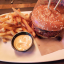

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


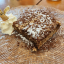

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


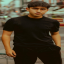

--------------------
Img real: Personas -> Pred: Personas
   [Acuerdo] -> CORRECTO


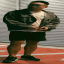

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


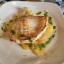

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


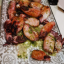

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


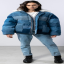

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


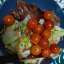

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


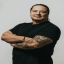

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


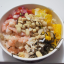

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


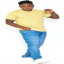

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


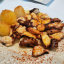

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


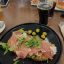

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


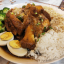

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


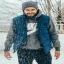

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


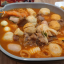

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


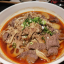

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


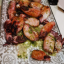

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


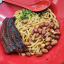

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


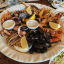

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


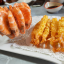

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


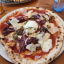

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


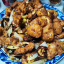

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


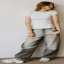

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


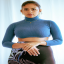

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


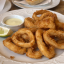

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


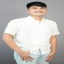

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


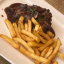

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


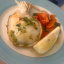

--------------------
Img real: Personas -> Pred: Personas
   [Acuerdo] -> CORRECTO


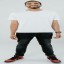

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


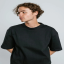

--------------------
Img real: Personas -> Pred: Personas
   [Conflicto -> Gana MVN] -> CORRECTO


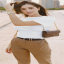

--------------------
Img real: Comidas -> Pred: Comidas
   [Acuerdo] -> CORRECTO


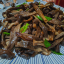

--------------------

ESTADÍSTICAS FINALES:
Precisión Global: 100.00%
Conflictos entre KNN y centroides: 10 de 33 casos.

Clases: [np.str_('Comidas'), np.str_('Personas')]
Matriz de confusión (filas=real, cols=pred):
 [[21  0]
 [ 0 12]]
Comidas: Precision=100.0%  Recall=100.0%
Personas: Precision=100.0%  Recall=100.0%


In [34]:
import cv2
import numpy as np
import os
import random
from google.colab.patches import cv2_imshow

#Extracción de características
def extraer_caracteristicas(ruta_imagen, alpha_color=3.0, beta_hog=1.0):
    img = cv2.imread(ruta_imagen)
    if img is None:
        return None

    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)

    #Histograma HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [12, 8, 8], [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, None).flatten().astype(np.float32)

    #Forma/Textura: HOG
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog = cv2.HOGDescriptor(
        _winSize=(64, 64),
        _blockSize=(16, 16),
        _blockStride=(8, 8),
        _cellSize=(8, 8),
        _nbins=9
    )
    hog_desc = hog.compute(gray).flatten().astype(np.float32)

    #Fusion
    vector = np.concatenate([alpha_color * hist, beta_hog * hog_desc]).astype(np.float32)
    return vector, img

#Distancia y estandarización
def distancia_euclidiana(v1, v2):
    diff = v1 - v2
    return np.sqrt(np.dot(diff, diff))

def fit_standardizer(X_train):
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0)
    sigma[sigma < 1e-8] = 1.0
    return mu, sigma

def transform_standardizer(X, mu, sigma):
    return (X - mu) / sigma

#Algoritmo KNN balanceado
def obtener_voto_knn_balanceado(k, X_train, y_train, vector_nuevo, eps=1e-9):
    clases, counts = np.unique(y_train, return_counts=True)
    w_class = {c: 1.0 / counts[i] for i, c in enumerate(clases)}

    distancias = []
    for i in range(len(X_train)):
        d = distancia_euclidiana(vector_nuevo, X_train[i])
        distancias.append((d, y_train[i]))

    distancias.sort(key=lambda x: x[0])
    vecinos = distancias[:k]

    votos = {}
    for d, etiqueta in vecinos:
        w_dist = 1.0 / (d + eps)
        votos[etiqueta] = votos.get(etiqueta, 0.0) + w_dist * w_class[etiqueta]

    return max(votos.items(), key=lambda x: x[1])[0]

#Algoritmo MVN
def entrenar_centroides(X_train, y_train):
    centroides = {}
    for c in np.unique(y_train):
        centroides[c] = X_train[y_train == c].mean(axis=0)
    return centroides

def obtener_voto_centroides(centroides, vector_nuevo):
    mejor_clase = None
    mejor_dist = float("inf")
    for c, centro in centroides.items():
        d = distancia_euclidiana(vector_nuevo, centro)
        if d < mejor_dist:
            mejor_dist = d
            mejor_clase = c
    return mejor_clase

#Sistema híbrido(Para esta versión se ha cogido en caso de conflicto MVN
#porque tiene más porcentaje de aciertos)
def clasificador_hibrido(vector, X_train, y_train, centroides, k=5):
    voto_knn = obtener_voto_knn_balanceado(k, X_train, y_train, vector)
    voto_cent = obtener_voto_centroides(centroides, vector)

    if voto_knn == voto_cent:
        return voto_knn, "Acuerdo"
    else:
        return voto_cent, "Conflicto -> Gana MVN"

def split_estratificado_aleatorio(y, test_ratio=0.2, seed=None):
    """
    Devuelve idx_train e idx_test aleatorios, manteniendo proporción por clase.
    Si seed=None, cada ejecución dará un split distinto.
    """
    if seed is not None:
        random.seed(seed)

    idx_por_clase = {}
    for i, etiqueta in enumerate(y):
        idx_por_clase.setdefault(etiqueta, []).append(i)

    idx_train, idx_test = [], []
    for etiqueta, idxs in idx_por_clase.items():
        random.shuffle(idxs)
        n_test = max(1, int(len(idxs) * test_ratio))
        idx_test.extend(idxs[:n_test])
        idx_train.extend(idxs[n_test:])

    random.shuffle(idx_train)
    random.shuffle(idx_test)
    return idx_train, idx_test

#Elegir el K mejor
def elegir_mejor_k(X_train, y_train, ks=(3, 5, 7, 9), seed=None):
    if seed is not None:
        random.seed(seed)

    idx = list(range(len(X_train)))
    random.shuffle(idx)
    cut = int(len(idx) * 0.8)
    idx_tr, idx_val = idx[:cut], idx[cut:]

    X_tr, y_tr = X_train[idx_tr], y_train[idx_tr]
    X_val, y_val = X_train[idx_val], y_train[idx_val]

    mejor_k, mejor_acc = ks[0], -1.0
    for k in ks:
        centroides = entrenar_centroides(X_tr, y_tr)
        ok = 0
        for i in range(len(X_val)):
            pred, _ = clasificador_hibrido(X_val[i], X_tr, y_tr, centroides, k=k)
            ok += int(pred == y_val[i])
        acc = ok / max(1, len(X_val))
        if acc > mejor_acc:
            mejor_acc = acc
            mejor_k = k

    return mejor_k, mejor_acc

#Matriz confusión y métricas por clase
def resumen_clasificacion(y_true, y_pred):
    clases = sorted(list(set(y_true)))
    idx = {c: i for i, c in enumerate(clases)}
    cm = np.zeros((len(clases), len(clases)), dtype=int)

    for t, p in zip(y_true, y_pred):
        cm[idx[t], idx[p]] += 1

    print("\nClases:", clases)
    print("Matriz de confusión (filas=real, cols=pred):\n", cm)

    for c in clases:
        i = idx[c]
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        recall = tp / (tp + fn + 1e-9)
        prec = tp / (tp + fp + 1e-9)
        print(f"{c}: Precision={prec*100:.1f}%  Recall={recall*100:.1f}%")


#Programa principal
def main():
    ruta_base = "/content"
    carpetas = ["Personas", "Comidas"]

    alpha_color = 3.0
    beta_hog = 1.0

    #Cada ejecución hace un split distinto
    seed_split = None

    print("--- CARGANDO Y PROCESANDO IMÁGENES ---")

    X, y, imagenes_visuales = [], [], []

    if not os.path.exists(ruta_base):
        print(f"No encuentro la carpeta {ruta_base}")
        return

    for carpeta in carpetas:
        ruta_completa = os.path.join(ruta_base, carpeta)
        if not os.path.exists(ruta_completa):
            print(f"No encuentro la subcarpeta '{ruta_completa}'")
            continue

        archivos = os.listdir(ruta_completa)
        #barajar archivos
        random.shuffle(archivos)

        print(f"Leyendo {len(archivos)} archivos en '{carpeta}'")

        for archivo in archivos:
            if archivo.lower().endswith((".jpg", ".jpeg", ".png")):
                ruta_img = os.path.join(ruta_completa, archivo)
                res = extraer_caracteristicas(ruta_img, alpha_color=alpha_color, beta_hog=beta_hog)
                if res is not None:
                    vector, img_orig = res
                    X.append(vector)
                    y.append(carpeta)
                    imagenes_visuales.append(img_orig)

    X = np.array(X, dtype=np.float32)
    y = np.array(y)

    print(f"\nTotal imágenes válidas cargadas: {len(X)}")
    if len(X) < 10:
        print("No hay suficientes imágenes para entrenar.")
        return

    #Split aleatorios (train/test aleatorios)
    idx_train, idx_test = split_estratificado_aleatorio(y, test_ratio=0.2, seed=seed_split)

    X_train, y_train = X[idx_train], y[idx_train]
    X_test, y_test = X[idx_test], y[idx_test]
    imgs_test = [imagenes_visuales[i] for i in idx_test]

    print(f"Entrenamiento: {len(X_train)} imágenes")
    print(f"Test: {len(X_test)} imágenes")

    mu, sigma = fit_standardizer(X_train)
    X_train = transform_standardizer(X_train, mu, sigma)
    X_test = transform_standardizer(X_test, mu, sigma)

    #Elegir K
    ks = (3, 5, 7, 9)
    mejor_k, acc_val = elegir_mejor_k(X_train, y_train, ks=ks, seed=None)
    print(f"\nMejor K estimado: {mejor_k} (acc val interna ~ {acc_val*100:.1f}%)")

    #Entrenamiento de centroides
    centroides = entrenar_centroides(X_train, y_train)

    # Mostrar casos aleatorios en test
    orden_test = list(range(len(X_test)))
    random.shuffle(orden_test)

    print("\n" + "=" * 40)
    print("INICIANDO CLASIFICACIÓN")
    print("=" * 40)

    aciertos, conflictos = 0, 0
    preds = []
    y_true_shuffled = []

    for j in orden_test:
        pred, confianza = clasificador_hibrido(X_test[j], X_train, y_train, centroides, k=mejor_k)
        preds.append(pred)
        y_true_shuffled.append(y_test[j])

        ok = (pred == y_test[j])
        aciertos += int(ok)
        conflictos += int("Conflicto" in confianza)

        print(f"Img real: {y_test[j]} -> Pred: {pred}")
        print(f"   [{confianza}] -> {'CORRECTO' if ok else 'FALLO'}")

        cv2_imshow(imgs_test[j])
        print("-" * 20)

    precision = (aciertos / len(X_test)) * 100
    print(f"\nESTADÍSTICAS FINALES:")
    print(f"Precisión Global: {precision:.2f}%")
    print(f"Conflictos entre KNN y centroides: {conflictos} de {len(X_test)} casos.")

    # Métricas por clase (usando el mismo orden aleatorio mostrado)
    resumen_clasificacion(y_true_shuffled, preds)


if __name__ == "__main__":
    main()
